# Importación de Bibliotecas



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
import os

# Conexión a DataSet Covid-19 Drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Descripción del DataSet
** ____ 
**

In [ ]:
labels = ['POSITIVO', 'NEGATIVO']
img_size = 150
def carga_img(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping a las imágenes
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

# Carga del Dataset

In [ ]:
train = carga_img('/content/drive/MyDrive/DSET_COVID/train')
test = carga_img('/content/drive/MyDrive/DSET_COVID/test')
val = carga_img('/content/drive/MyDrive/DSET_COVID/val')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  from ipykernel import kernelapp as app


# EDA

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


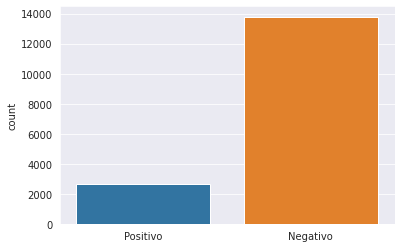

In [ ]:
l = []
for i in train:
    if(i[1] == 0):
        l.append("Positivo")
    else:
        l.append("Negativo")
sns.set_style('darkgrid')
sns.countplot(l)     

**Los datos están desbalanceados. Para aumentar el nro. de ejemplos de capacitación, usaremos data augmentation**


# Previsualización de imágenes por clase


Text(0.5, 1.0, 'NEGATIVO')

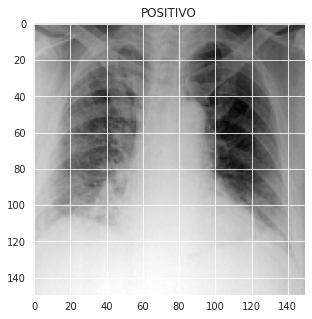

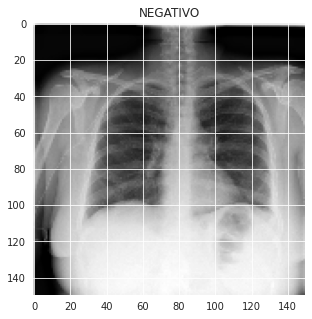

In [ ]:
plt.figure(figsize = (5,5))
plt.imshow(train[0][0], cmap='gray')
plt.title(labels[train[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[-1][0], cmap='gray')
plt.title(labels[train[-1][1]])

In [ ]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

#x_img = []
#y_img = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

#for feature, label in val:
#    x_img.append(feature)
#    y_img.append(label)

** Realizamos una normalización en escala de grises para reducir el efecto de las diferencias de iluminación. Además, la CNN converge más rápido en [0..1] datos que en [0..255].**

In [ ]:
# Normalizar los conjuntos de datos
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255
#x_img = np.array(x_img) / 255

In [ ]:
# cambiar el tamaño de los datos 
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

#x_img = x_img.reshape(-1, img_size, img_size, 1)
#y_img = np.array(y_img)

In [ ]:
#len(x_train)
print(y_train)

[0 0 0 ... 1 1 1]


# Data Augmentation


Para el aumento de datos, se declaró lo siguiente:

1. Rotar aleatoriamente algunas imágenes de entrenamiento en 30 grados
2. Zoom aleatorio en un 20% algunas imágenes de entrenamiento
3. Desplazar aleatoriamente las imágenes horizontalmente en un 10% del ancho
4. Desplazar aleatoriamente las imágenes verticalmente en un 10% de la altura
5. Voltear aleatoriamente las imágenes horizontalmente. 
Por ultimo se hace fit (entrenamiento) el conjunto de datos.

In [ ]:
# Con aumento de datos para evitar el sobreajuste y el manejo del desequilibrio en el conjunto de datos

datagen = ImageDataGenerator(
        featurewise_center=False,  # establecer la media de entrada en 0 sobre el conjunto de datos
        samplewise_center=False,  # establecer cada media de muestra en 0
        featurewise_std_normalization=False,  # dividir las entradas por std del conjunto de datos
        samplewise_std_normalization=False,  # dividir cada entrada por la std
        zca_whitening=False,  # applicar ZCA whitening
        rotation_range = 30,  # rotar aleatoriamente imágenes en el rango (grados, 0 a 180)
        zoom_range = 0.2, # Zoom aleatorio de la imagen
        width_shift_range=0.1,  # desplazar aleatoriamente las imágenes horizontalmente (fracción del ancho total)
        height_shift_range=0.1,  # desplazar aleatoriamente las imágenes verticalmente (fracción de la altura total)
        horizontal_flip = True,  # voltear imágenes al azar horizontal
        vertical_flip=False)  # voltear imágenes al azar vertical


datagen.fit(x_train)

# **Entrenamiento del Modelo**

In [ ]:
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 150, 150, 32)      320       
_________________________________________________________________
batch_normalization_5 (Batch (None, 150, 150, 32)      128       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
dropout_4 (Dropout)          (None, 75, 75, 64)        0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 75, 75, 64)        256       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 38, 38, 64)       

In [ ]:
taza_aprend_redux = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [ ]:
history = model.fit(datagen.flow(x_train,y_train, batch_size = 32) ,epochs = 10 , validation_data = datagen.flow(x_val, y_val) ,callbacks = [taza_aprend_redux])

Epoch 1/10
515/515 [==============================] - 1247s 2s/step - loss: 0.3972 - accuracy: 0.8543 - val_loss: 1.3332 - val_accuracy: 0.5000
Epoch 2/10
515/515 [==============================] - 1261s 2s/step - loss: 0.3040 - accuracy: 0.8926 - val_loss: 3.5811 - val_accuracy: 0.5000
Epoch 3/10
515/515 [==============================] - 1269s 2s/step - loss: 0.2590 - accuracy: 0.9076 - val_loss: 0.2712 - val_accuracy: 0.8667
Epoch 4/10
515/515 [==============================] - 1267s 2s/step - loss: 0.2394 - accuracy: 0.9151 - val_loss: 0.6026 - val_accuracy: 0.7667
Epoch 5/10
515/515 [==============================] - 1261s 2s/step - loss: 0.2345 - accuracy: 0.9215 - val_loss: 1.0565 - val_accuracy: 0.5667

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 6/10
515/515 [==============================] - 1262s 2s/step - loss: 0.1683 - accuracy: 0.9437 - val_loss: 0.4127 - val_accuracy: 0.7667
Epoch 7/10
515/515 [==============================] - 1

In [ ]:
print("La pérdida del modelo es - " , model.evaluate(x_test,y_test)[0])
print("La precisión del modelo es - " , model.evaluate(x_test,y_test)[1]*100 , "%")

12/12 [==============================] - 5s 418ms/step - loss: 0.1709 - accuracy: 0.9432
Loss of the model is -  0.17094898223876953
12/12 [==============================] - 5s 414ms/step - loss: 0.1709 - accuracy: 0.9432
Accuracy of the model is -  94.32432651519775 %


# Análisis del Entrenamiento




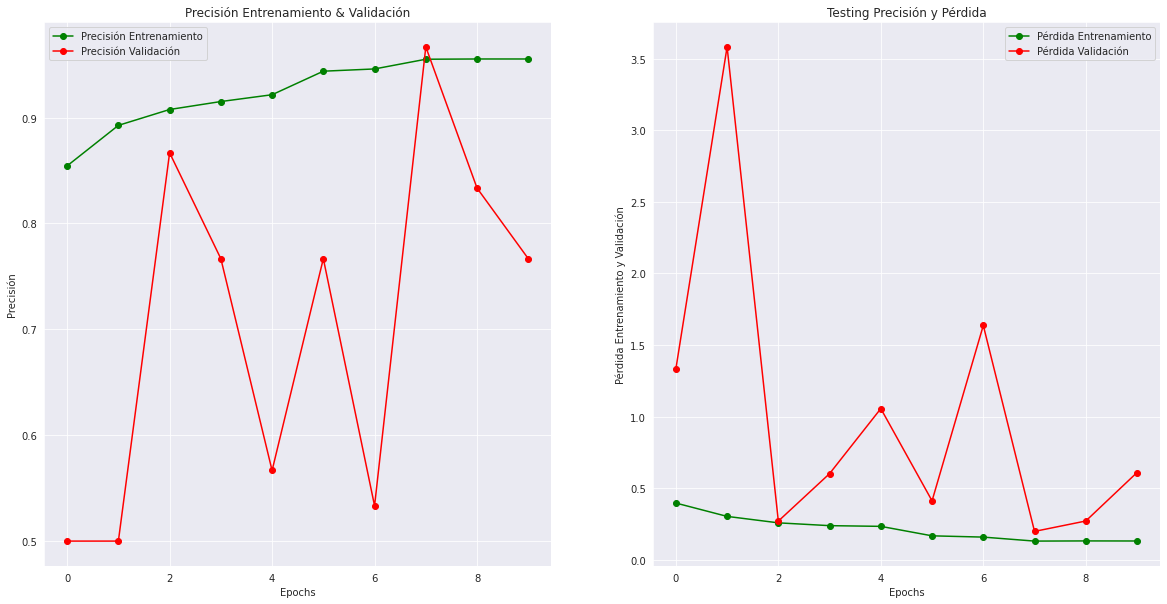

In [ ]:
epochs = [i for i in range(10)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Precisión Entrenamiento')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Precisión Validación')
ax[0].set_title('Precisión Entrenamiento & Validación')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Precisión")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Pérdida Entrenamiento')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Pérdida Validación')
ax[1].set_title('Testing Precisión y Pérdida')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Pérdida Entrenamiento y Validación")
plt.show()

# Predicciones

In [ ]:
predict = model.predict_classes(x_test)
predict = predictions.reshape(1,-1)[0]
predict[:15]

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [ ]:
print(classification_report(y_test, predict, target_names = ['POSITIVO (Class 0)','NEGATIVO (Class 1)']))

                    precision    recall  f1-score   support

POSITIVO (Class 0)       0.91      0.99      0.95       185
NEGATIVO (Class 1)       0.99      0.90      0.94       185

          accuracy                           0.94       370
         macro avg       0.95      0.94      0.94       370
      weighted avg       0.95      0.94      0.94       370



In [ ]:
mc = confusion_matrix(y_test,predict)
mc

array([[183,   2],
       [ 19, 166]])

In [ ]:
mc = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])


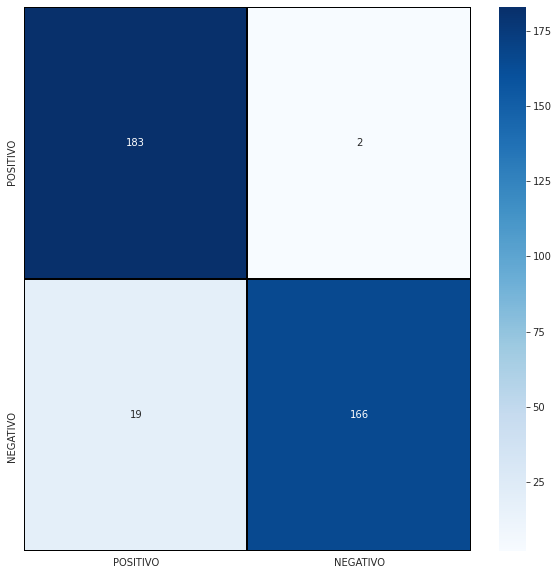

In [ ]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)

In [ ]:
correcto = np.nonzero(predict == y_test)[0]
incorrecto = np.nonzero(predict != y_test)[0]

**Ejemplos predichos de forma correcta**

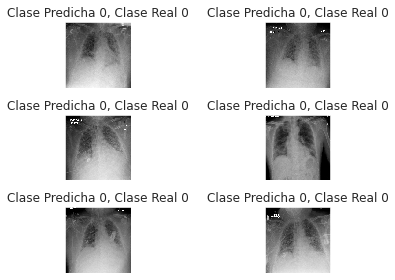

In [ ]:
i = 0
for c in correcto[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Clase Predicha {}, Clase Real {}".format(predict[c], y_test[c]))
    plt.tight_layout()
    i += 1

**Ejemplos predichos de forma incorrecta**

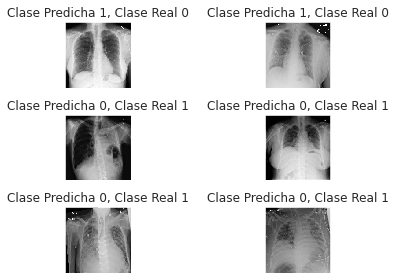

In [ ]:
i = 0
for c in incorrecto[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Clase Predicha {}, Clase Real {}".format(predict[c], y_test[c]))
    plt.tight_layout()
    i += 1

In [ ]:
model.save('/content/drive/MyDrive/modelo_t1.h5')